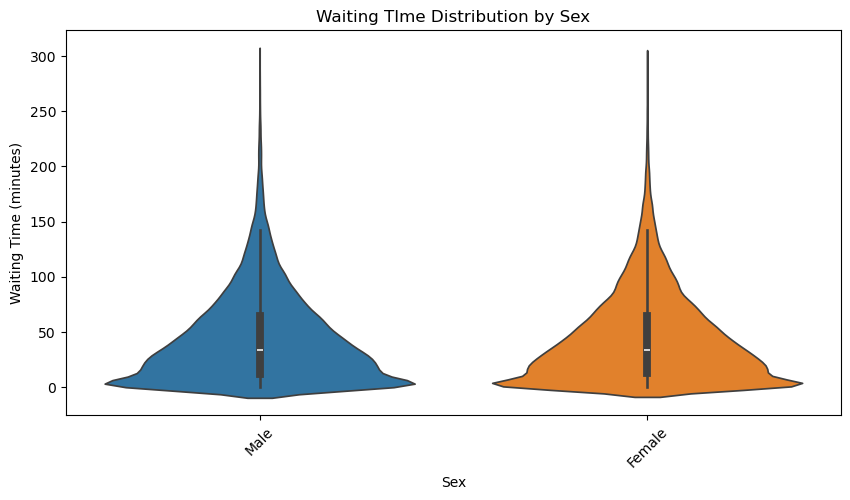

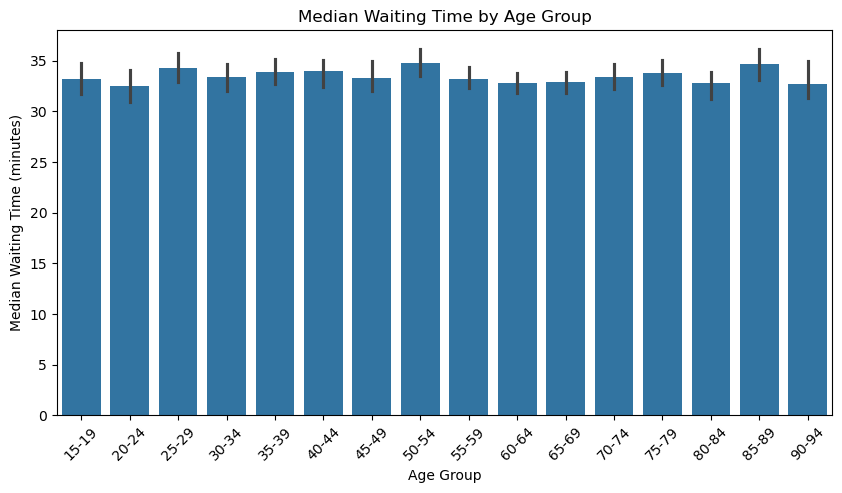

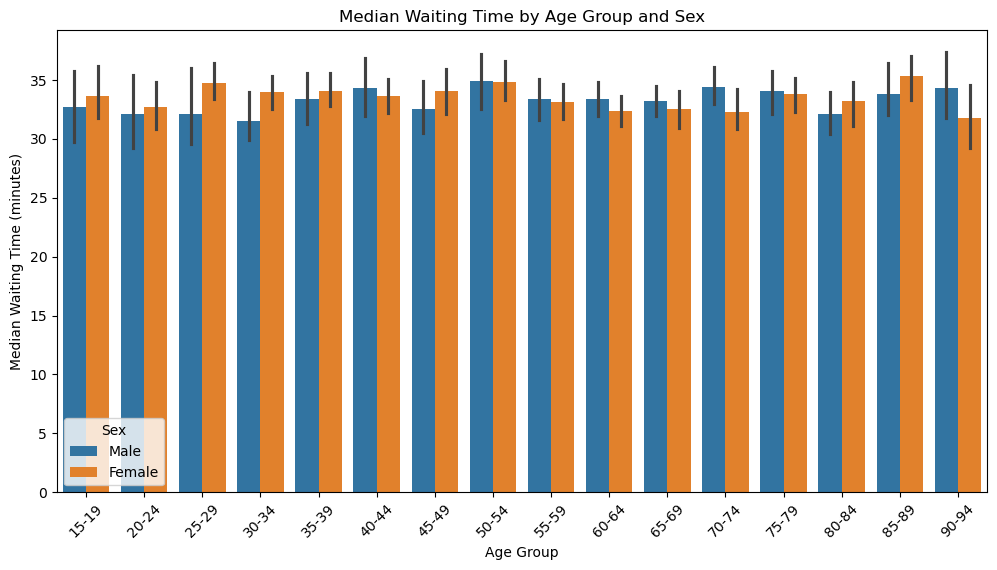

          Actual  Predicted
74666  -1.051435   0.207200
18086   0.010137  -0.022223
39283  -1.056338  -0.008815
56110  -0.264449  -0.036386
45120  -1.048983  -0.101490
103634  0.346016   0.457680
89311  -0.754783   0.196050
105815 -0.668975  -0.092878
74533  -1.061242   0.265723
55713  -0.713105   0.018368
Mean Absolute Error (MAE): 0.7806372924202166
R² Score: -0.014545536468219211
The poor R² score tells us that age and sex alone do not explain the variation in waiting time. Other factors such as time of day, clinic busyness, patient punctuality, or appointment type are likely more influential.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load datasets
slots_df = pd.read_csv("slots.csv")
patients_df = pd.read_csv("patients.csv")
appointments_df = pd.read_csv("appointments.csv")

# Check for null values
# print("Missing Values for Slots:\n",slots_df.isnull().sum())
# print("Missing Values for Patients:\n",patients_df.isnull().sum())
# print("Missing Values for Appointments:\n",appointments_df.isnull().sum())

# Check for duplicates
# print("Duplicates in Slots:",slots_df.duplicated().sum())
# print("Duplicates in Patients:",patients_df.duplicated().sum())
# print("Duplicates in Appointments:",appointments_df.duplicated().sum())

# Summary statistics for numerical columns
# print("Slots Summary:\n", slots_df.describe())
# print("Patients Summary:\n", patients_df.describe())
# print("Appointments Summary:\n", appointments_df.describe())

# Print rows for structure
# print(slots_df.head())
# print(patients_df.head())
# print(appointments_df.head())

# Drop rows with missing values. Rows won't be needed for analysing wait time as they are missed appointments so data will not be lost
appointments_df.dropna(inplace=True)

# Encode Sex Variables
patients_df['sex'] = patients_df['sex'].map({'Male' : 0, 'Female': 1})

# Extract day of the week
appointments_df['appointment_date'] = pd.to_datetime(appointments_df['appointment_date'])
appointments_df['appointment_day'] = appointments_df['appointment_date'].dt.dayofweek

# Age calculation
reference_date = datetime(2024, 12, 1)
patients_df['dob'] = pd.to_datetime(patients_df['dob'])
patients_df['age'] = (reference_date - patients_df['dob']).dt.days // 365 # Convert days to years
# print(patients_df[['dob', 'age']].head())

# Create age groups
bins = list(range(15, 100, 5))
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
appointments_df['age_group'] = pd.cut(appointments_df['age'], bins=bins, labels=labels, right=False)

# Violin Plot for Waiting Time by Sex
plt.figure(figsize=(10,5))
sns.violinplot(x="sex", y="waiting_time", data=appointments_df, hue="sex")
plt.xlabel("Sex")
plt.ylabel("Waiting Time (minutes)")
plt.title("Waiting TIme Distribution by Sex")
plt.xticks(rotation=45) # Rotates labels for readability
plt.show()

# Bar Chart with Median Waiting Time for Age Group
plt.figure(figsize=(10,5))
sns.barplot(x="age_group", y="waiting_time", data=appointments_df, estimator=np.median)
plt.xlabel("Age Group")
plt.ylabel("Median Waiting Time (minutes)")
plt.title("Median Waiting Time by Age Group")
plt.xticks(rotation=45)
plt.show()

# Clustered Bar Chart for Wait Time by Age Group and Sex
plt.figure(figsize=(12,6))
sns.barplot(x="age_group", y="waiting_time", hue="sex", data=appointments_df, estimator=np.median)
plt.xlabel("Age Group")
plt.ylabel("Median Waiting Time (minutes)")
plt.title("Median Waiting Time by Age Group and Sex")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.show()

# Machine Learning From Here

# Convert age_group to numerical values
appointments_df['age_group'] = appointments_df['age_group'].astype('category').cat.codes

# Scaling for machine learning models
scaler = StandardScaler()
columns_to_scale = ['waiting_time', 'age_group', 'appointment_day']
# Apply scaling
appointments_df[columns_to_scale] = scaler.fit_transform(appointments_df[columns_to_scale])

# Select features (X) and target (y)
X = appointments_df[['age_group', 'sex', 'appointment_day', 'appointment_duration']]
y = appointments_df['waiting_time']

# Encode categorical variables
X = pd.get_dummies(X, columns=['sex', 'appointment_day'], drop_first=True)

# Add interaction term
X['age_sex_interaction'] = X['age_group'] * X['sex_Male']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
# model = DecisionTreeRegressor(max_depth=15, random_state=42)
model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)

# Train model
model.fit(X_train, y_train)

# Make prediciton
y_pred = model.predict(X_test)

# Convert predicitons into a df for easy comparison
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head(10))

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

print('The poor R² score tells us that age and sex alone do not explain the variation in waiting time. Other factors such as time of day, clinic busyness, patient punctuality, or appointment type are likely more influential.') 